In [15]:
import seaborn as sns
from typing import Union
from sklearn.decomposition import non_negative_factorization
import numpy as np
import scanpy as sc
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
import functools
from anndata import AnnData
import scvi
import torch

In [7]:
from scvi.module.base import (
    BaseMinifiedModeModuleClass,
    EmbeddingModuleMixin,
    LossOutput,
    auto_move_data,
)

from scvi.nn import Encoder

In [394]:
def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

def cosine_similarity_rows(A: np.array, B: np.array) -> np.array:
    norms_A = np.linalg.norm(A, axis=1)
    norms_B = np.linalg.norm(B, axis=1)
    dot_products = np.einsum('ij,ij->i', A, B)
    return dot_products / (norms_A * norms_B)

evaluate_model_data_reconstruction = lambda model_eval, data: torch.hstack([model_eval(torch.Tensor(np.where(gene_mask, data, 0)))[:, gene_mask] for gene_mask in np.eye(data.shape[1], dtype=bool)])

def benchmark_reconstruction(count_matrix: np.array, count_matrix_reconstructed: np.array) -> None:

    if isinstance(count_matrix, torch.Tensor):
        count_matrix = count_matrix.detach().numpy()
    if isinstance(count_matrix_reconstructed, torch.Tensor):
        count_matrix_reconstructed = count_matrix_reconstructed.detach().numpy()

    log_original = np.log1p(count_matrix)
    log_reconstructed = np.log1p(count_matrix_reconstructed)

    row_means_original = count_matrix.mean(axis=1)
    row_means_reconstructed = count_matrix_reconstructed.mean(axis=1)
    col_means_original = count_matrix.mean(axis=0)
    col_means_reconstructed = count_matrix_reconstructed.mean(axis=0)

    fig, axes = plt.subplots(3, 2, figsize=(6, 8))

    sns.heatmap(log_original, ax=axes[0, 0], cmap="magma", cbar=True)
    axes[0, 0].set_title("Log Transformed \n Original Count Matrix")

    sns.heatmap(log_reconstructed, ax=axes[0, 1], cmap="magma", cbar=True)
    axes[0, 1].set_title("Log Transformed \n Reconstructed Count Matrix")

    pearson_row, _ = pearsonr(row_means_original, row_means_reconstructed)
    axes[1, 0].scatter(row_means_original, row_means_reconstructed, alpha=0.5, color="black")
    axes[1, 0].plot([row_means_original.min(), row_means_original.max()], 
                    [row_means_original.min(), row_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 0].set_xlabel("Cell Mean (Original)")
    axes[1, 0].set_ylabel("Cell Mean (Reconstructed)")
    axes[1, 0].set_title("Cell-wise Mean Comparison")
    axes[1, 0].text(0.05, 0.9, f"Pearson r = {pearson_row:.2f}", 
                    transform=axes[1, 0].transAxes, fontsize=10, color="blue")
    
    pearson_col, _ = pearsonr(col_means_original, col_means_reconstructed)
    axes[1, 1].scatter(col_means_original, col_means_reconstructed, alpha=0.5, color="black")
    axes[1, 1].plot([col_means_original.min(), col_means_original.max()], 
                    [col_means_original.min(), col_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 1].set_xlabel("Gene Mean (Original)")
    axes[1, 1].set_ylabel("Gene Mean (Reconstructed)")
    axes[1, 1].set_title("Gene-wise Mean Comparison")
    axes[1, 1].text(0.05, 0.9, f"Pearson r = {pearson_col:.2f}", 
                    transform=axes[1, 1].transAxes, fontsize=10, color="blue")

    sns.violinplot(cosine_similarity_rows(count_matrix, count_matrix_reconstructed), ax=axes[2, 0])
    axes[2, 0].set_title("Cosine Similarity Cells")
    sns.violinplot(cosine_similarity_rows(count_matrix.T, count_matrix_reconstructed.T), ax=axes[2, 1])
    axes[2, 1].set_title("Cosine Similarity Genes")

    sns.despine()
    plt.tight_layout()
    plt.show()

In [432]:
celltype = "Stem/TA"
adata_sp = (lambda x: x[x.obs["nico_ct"] == celltype].copy())(sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad"))
#adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = (lambda x: x[x.obs["cluster"] == celltype].copy())(sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad"))
#adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
#sc.pp.filter_genes(adata_sp, min_counts=50)
#sc.pp.filter_genes(adata_sc, min_counts=50)
sc.pp.filter_genes(adata_sp, min_counts=20)
sc.pp.filter_genes(adata_sc, min_counts=20)
shared_genes_mask_sc = np.isin(adata_sc.var_names, adata_sp.var_names)
shared_genes_mask_sp = np.isin(adata_sp.var_names, adata_sc.var_names)
shared_genes = adata_sc[:, shared_genes_mask_sc].var_names
print(f"{len(shared_genes)=}")

len(shared_genes)=63


In [433]:
adata_sc = adata_sc[:, shared_genes_mask_sc].copy()
adata_sp = adata_sp[:, shared_genes].copy()

In [412]:
scvi.model.SCVI.setup_anndata(adata_sc)
model_scvi = scvi.model.SCVI(adata_sc)
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [413]:
model_scvi.train()

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of t

Epoch 400/400: 100%|██████████| 400/400 [00:10<00:00, 36.86it/s, v_num=1, train_loss_step=80, train_loss_epoch=78.6]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:10<00:00, 37.56it/s, v_num=1, train_loss_step=80, train_loss_epoch=78.6]


In [414]:
model_scvi.module.forward()

TypeError: BaseModuleClass.forward() missing 1 required positional argument: 'tensors'

In [420]:
model_scvi.get_normalized_expression(sc.AnnData(
    X=np.where(np.isin(shared_genes, shared_genes[0]), adata_sc[:, shared_genes].X.toarray(), 0),
    var=adata_sc.var
)
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


,Fzd7,Fzd5,Cps1,Gpr55,Mptx2,Vim,Cd44,Ada,Tm4sf4,Clca3b,...,Fzd8,Cd14,Slc12a2,Htr4,Neat1,Rcor2,Ffar4,Adra2a,Maoa,Maged2
0,0.005953,0.018156,0.085127,0.002100,0.002071,0.015670,0.010049,0.000991,0.000997,0.135060,...,0.003090,0.002096,0.100250,0.004623,0.051888,0.001662,0.004773,0.001858,0.025491,0.001179
1,0.001755,0.022779,0.075096,0.003352,0.004712,0.019046,0.002385,0.003165,0.008266,0.085804,...,0.002563,0.002668,0.067526,0.001140,0.009069,0.000527,0.004958,0.011775,0.017635,0.002765
2,0.002258,0.028142,0.086780,0.003114,0.014024,0.032699,0.004955,0.002236,0.005554,0.107783,...,0.004494,0.006319,0.083766,0.008161,0.039789,0.000936,0.005768,0.005772,0.020702,0.003178
3,0.000924,0.026966,0.074784,0.000704,0.008146,0.031823,0.001192,0.000520,0.001363,0.103905,...,0.001682,0.002235,0.078427,0.000854,0.037947,0.000172,0.004479,0.001443,0.024039,0.000803
4,0.000728,0.029139,0.097710,0.001834,0.026991,0.019555,0.002046,0.001811,0.001805,0.079402,...,0.002479,0.003549,0.054014,0.001011,0.035071,0.000463,0.005412,0.002450,0.030234,0.001967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.002122,0.020564,0.078680,0.003603,0.005702,0.021882,0.010920,0.001153,0.003446,0.134070,...,0.002599,0.007707,0.093447,0.000945,0.024230,0.001003,0.008069,0.002636,0.019562,0.002220
416,0.001733,0.019297,0.089342,0.002655,0.036258,0.014786,0.007932,0.002028,0.003189,0.106218,...,0.000938,0.003148,0.085080,0.002896,0.030802,0.001223,0.001305,0.004801,0.018491,0.002402
417,0.001203,0.025445,0.119688,0.001944,0.003939,0.014692,0.002397,0.000908,0.001329,0.109627,...,0.003045,0.008449,0.097627,0.000794,0.028127,0.000414,0.003753,0.000902,0.028690,0.001138
418,0.000789,0.021567,0.061432,0.003088,0.010066,0.059221,0.005921,0.002215,0.002375,0.064106,...,0.001747,0.008228,0.020831,0.000519,0.029234,0.000325,0.004749,0.000537,0.039885,0.001541


(array([[420.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [403.,  17.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1., 134., 235.,  41.,   9.,   0.,   0.,   0.,   0.,   0.],
        [420.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [420.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [413.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [420.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [420.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [420.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 22., 101., 118., 116.,  50.,  12.,   1.,   0.,   0.,   0.],
        [420.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [420.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 20., 130., 135.,  95.,  25.,  11.,   3.,   1.,   0.,   0.],
        [419.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [419.,   1.,

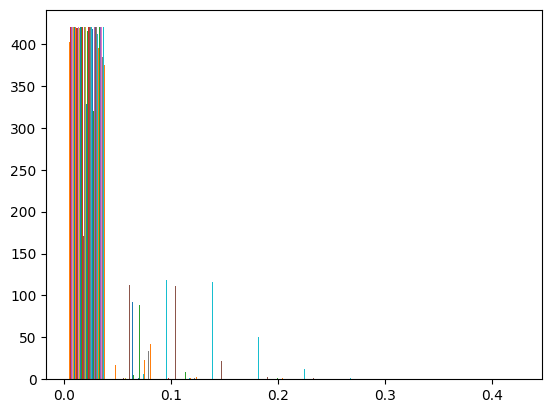

In [471]:
plt.hist(model_scvi.get_normalized_expression(adata_sc, return_mean=True, return_numpy=True))

In [357]:
evaluate_model_data_reconstruction = lambda model_eval, data: torch.hstack([model_eval(torch.Tensor(np.where(gene_mask, data, 0)))[:, gene_mask] for gene_mask in np.eye(data.shape[1], dtype=bool)])

In [108]:
from typing import Literal
class MyNeuralNet2(torch.nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int,
        link_var: Literal["exp", "none", "softmax"],
    ):
        """Encodes data of ``n_input`` dimensions into a space of ``n_output`` dimensions.

        Uses a one layer fully-connected neural network with 128 hidden nodes.

        Parameters
        ----------
        n_input
            The dimensionality of the input.
        n_output
            The dimensionality of the output.
        link_var
            The final non-linearity.
        """
        super().__init__()
        self.neural_net = torch.nn.Sequential(
            #torch.nn.Linear(n_input, 128),
            #torch.nn.ReLU(),
            #torch.nn.Linear(128, 128),
            #torch.nn.ReLU(),
            #torch.nn.Linear(128, 128),
            #torch.nn.ReLU(),
            #torch.nn.Linear(128, n_output)
            torch.nn.Linear(n_input, n_output)
        )
        self.transformation = None
        if link_var == "softmax":
            self.transformation = torch.nn.Softmax(dim=-1)
        elif link_var == "exp":
            self.transformation = torch.exp

    def forward(self, x: torch.Tensor):
        output = self.neural_net(x)
        if self.transformation:
            output = self.transformation(output)
        return output

In [110]:
MyNeuralNet2(20, 2, "softmax")

MyNeuralNet2(
  (neural_net): Sequential(
    (0): Linear(in_features=20, out_features=2, bias=True)
  )
  (transformation): Softmax(dim=-1)
)

In [111]:
Encoder(200,3)

Encoder(
  (encoder): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=200, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): None
        (3): ReLU()
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mean_encoder): Linear(in_features=128, out_features=3, bias=True)
  (var_encoder): Linear(in_features=128, out_features=3, bias=True)
)

In [71]:
class Linear_scvi_integration(EmbeddingModuleMixin, BaseMinifiedModeModuleClass):

    def __init__(
            self, 
            *args, 
            **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.encoder = Encoder()

In [122]:
adata_sc[:, shared_genes_mask_sc].var_names

Index(['Fzd7', 'Fzd5', 'Cps1', 'Gpr55', 'Mptx2', 'Vim', 'Cd44', 'Ada',
       'Tm4sf4', 'Clca3b', 'Lpar1', 'Marcksl1', 'Stmn1', 'C1qb', 'C1qc',
       'Ccnl2', 'Fzd1', 'Slc5a1', 'Kit', 'Gper1', 'Smo', 'Lrmp', 'Klk1',
       'Fzd4', 'Itgam', 'Mki67', 'Nlrp6', 'Trpm5', 'Acsl1', 'Hmgb2', 'Jaml',
       'Cmc1', 'Lgr5', 'Avil', 'Ccl9', 'Fzd2', 'Cd79b', 'Sdc1', 'Agr3',
       'Tspan13', 'Net1', 'Chrm3', 'Sox4', 'Txndc5', 'Il3ra', 'Lpar6',
       'Ptger4', 'Fzd6', 'Krt7', 'Slc51a', 'Ifnar1', 'H2-Eb1', 'Tnfrsf21',
       'Fzd8', 'Cd14', 'Slc12a2', 'Htr4', 'Neat1', 'Rcor2', 'Ffar4', 'Adra2a',
       'Maoa', 'Maged2'],
      dtype='object')

In [124]:
adata_sp[:, shared_genes].var_names

Index(['Fzd7', 'Fzd5', 'Cps1', 'Gpr55', 'Mptx2', 'Vim', 'Cd44', 'Ada',
       'Tm4sf4', 'Clca3b', 'Lpar1', 'Marcksl1', 'Stmn1', 'C1qb', 'C1qc',
       'Ccnl2', 'Fzd1', 'Slc5a1', 'Kit', 'Gper1', 'Smo', 'Lrmp', 'Klk1',
       'Fzd4', 'Itgam', 'Mki67', 'Nlrp6', 'Trpm5', 'Acsl1', 'Hmgb2', 'Jaml',
       'Cmc1', 'Lgr5', 'Avil', 'Ccl9', 'Fzd2', 'Cd79b', 'Sdc1', 'Agr3',
       'Tspan13', 'Net1', 'Chrm3', 'Sox4', 'Txndc5', 'Il3ra', 'Lpar6',
       'Ptger4', 'Fzd6', 'Krt7', 'Slc51a', 'Ifnar1', 'H2-Eb1', 'Tnfrsf21',
       'Fzd8', 'Cd14', 'Slc12a2', 'Htr4', 'Neat1', 'Rcor2', 'Ffar4', 'Adra2a',
       'Maoa', 'Maged2'],
      dtype='object')

In [117]:
len(shared_genes)

47

In [390]:
class Gene_Predictor(torch.nn.Module):
    def __init__(
            self,
            n_input,
            n_latent,
            n_output,
            *args,
            **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_input, n_latent),
            torch.nn.ReLU(),
            torch.nn.Linear(n_latent, n_output),
            torch.nn.ReLU(),
        )

        self.encoder = torch.nn.Linear(
            n_input,
            n_latent,
        )
        self.decoder = torch.nn.Linear(
            n_latent,
            n_output,
        )
    
    def forward(self, x):
        return self.net(x)

In [435]:
output_sp = []
output_sc = []
for gene in shared_genes:
    X, y = (lambda x, mask: (torch.Tensor(x[:, ~mask]), torch.Tensor(x[:, mask]).unsqueeze(1)))(
        x=adata_sc.X.toarray(),#[:, shared_genes_mask_sc],
        mask=np.isin(shared_genes, gene)
    )
    model = Gene_Predictor(
        n_input=len(shared_genes) - 1,
        n_latent=100,
        n_output=1
    )
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    for _ in range(100):
        model.train()
        outputs = model(X)
        loss = criterion(outputs, y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    #output.append(model(X).detach().numpy())
    output_sp.append(
        model(
            torch.Tensor(
                adata_sp[:, shared_genes].X.toarray()[:, ~np.isin(shared_genes, gene)]
            )
        ).detach().numpy()
    )
    output_sc.append(model(X).detach().numpy())


/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([420, 1, 1, 1])) that is different to the input size (torch.Size([420, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/1463299960.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


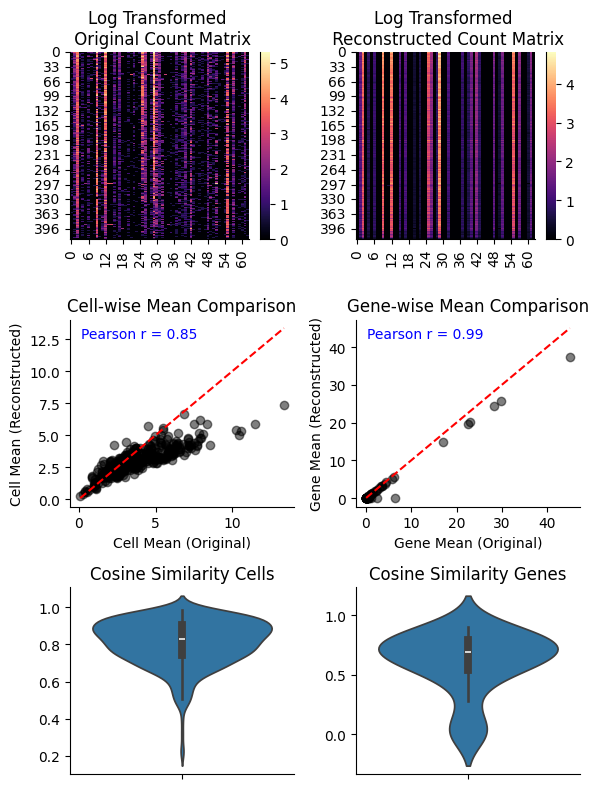

In [437]:
benchmark_reconstruction(adata_sc.X.toarray(), np.hstack(output_sc))

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/1463299960.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


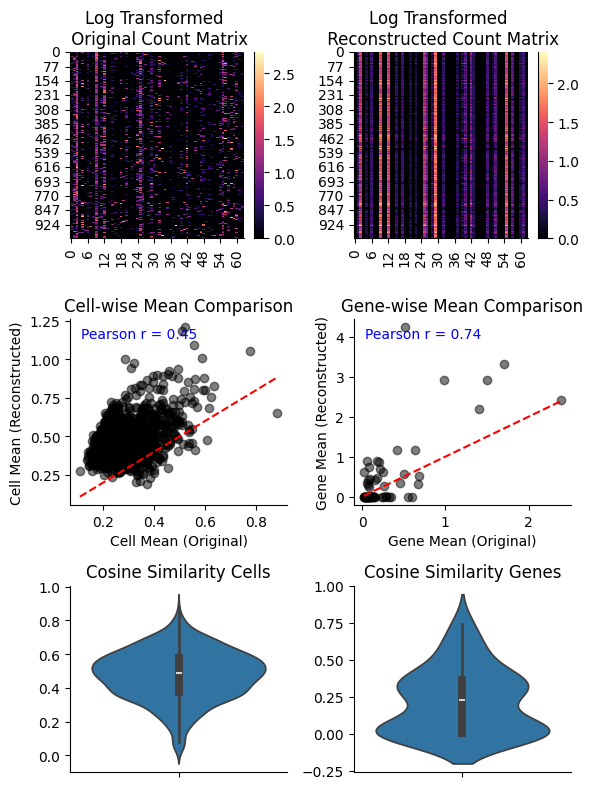

In [438]:
benchmark_reconstruction(adata_sp.X.toarray(), np.hstack(output_sp))

In [391]:
model2 = Gene_Predictor(
    n_input=len(shared_genes),
    n_latent=20,
    n_output=len(shared_genes)
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

X = torch.Tensor(adata_sc.X.toarray()[:, shared_genes_mask_sc])

for _ in range(100):
    model2.train()
    outputs = model2(X)
    loss = criterion(outputs, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/1463299960.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


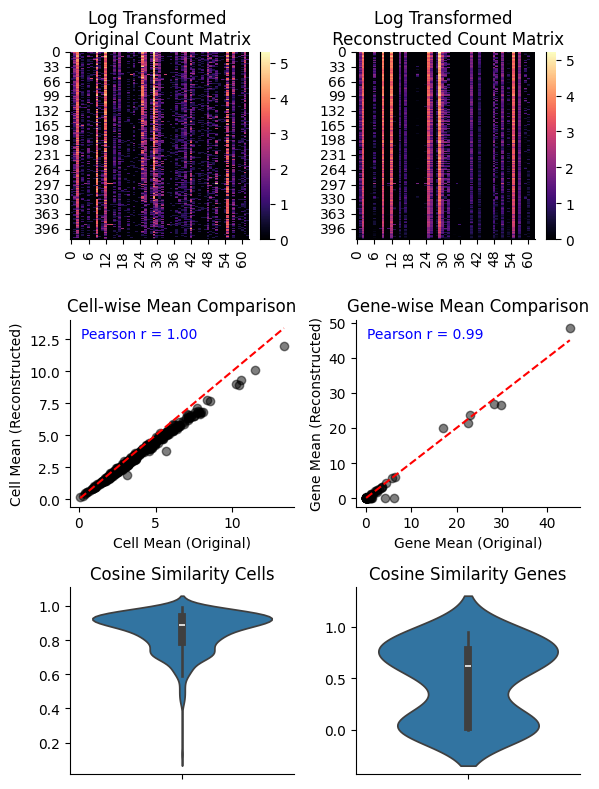

In [392]:
# evaluating the reconstruction quality of the single cell data
benchmark_reconstruction(X.detach().numpy(), model2(X).detach().numpy())

In [430]:
(lambda model_eval, data: benchmark_reconstruction(
    data,
    evaluate_model_data_reconstruction(model_eval, data)
))(
    model2,
    adata_sc[:, shared_genes_mask_sc].X.toarray()
)

IndexError: Boolean index does not match AnnData’s shape along this dimension. Boolean index has shape (11273,) while AnnData index has shape (63,).

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/1463299960.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


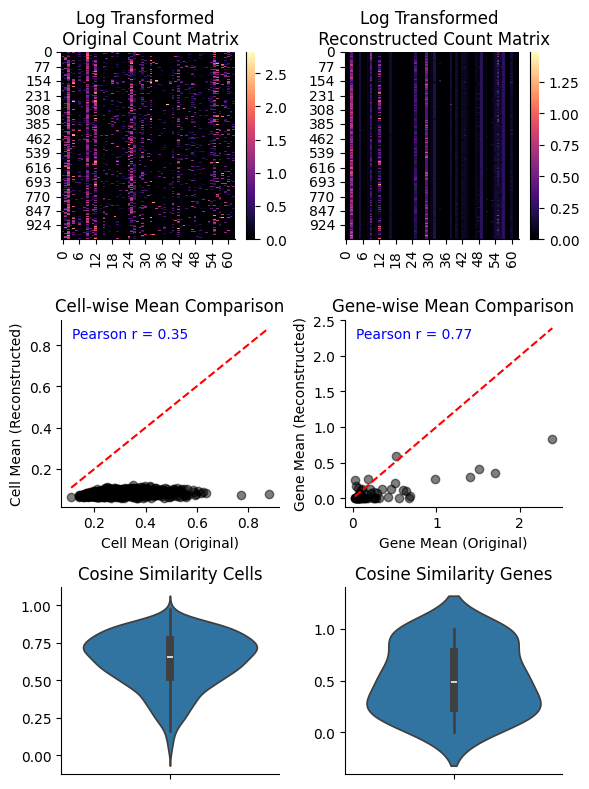

In [393]:
(lambda model_eval, data: benchmark_reconstruction(
    data,
    evaluate_model_data_reconstruction(model_eval, data)
))(
    model2,
    adata_sp[:, shared_genes].X.toarray()
)

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/1463299960.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


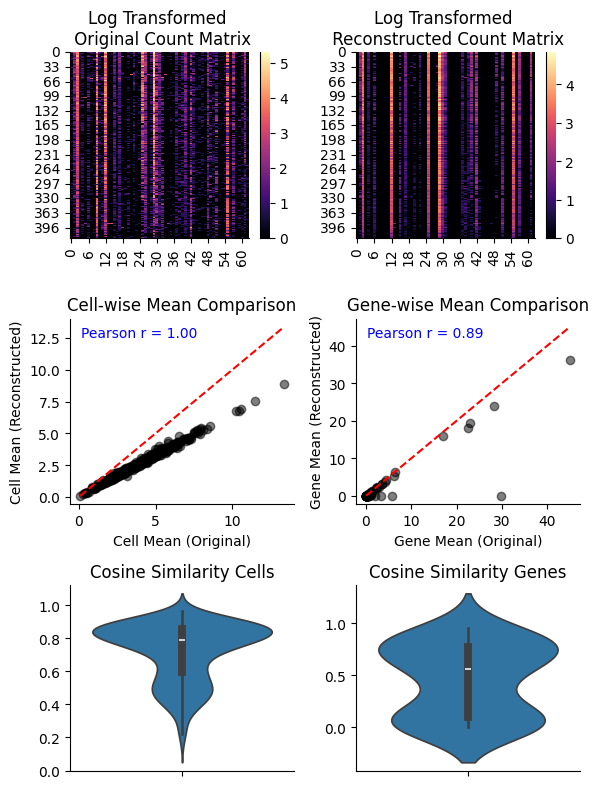

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/1463299960.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


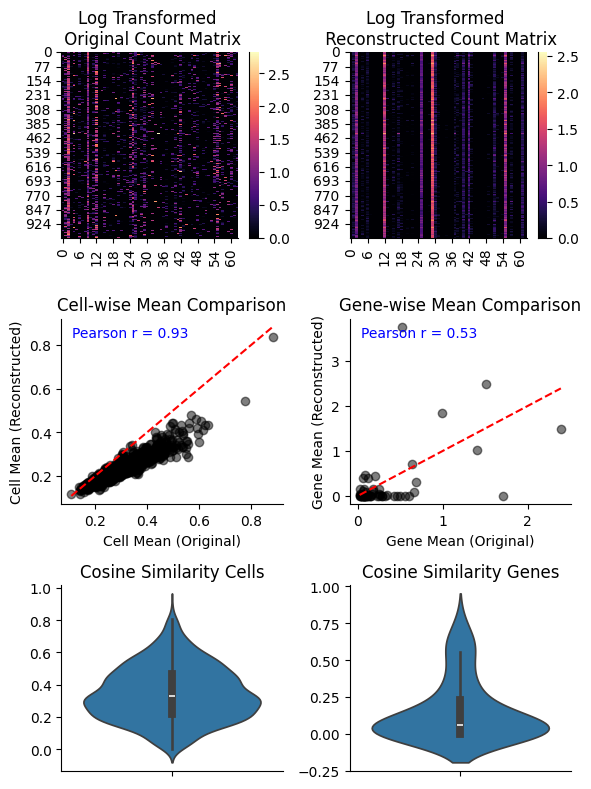

In [386]:
# iteratively reconstructing the original matrix by evaluating the autoencoder on the dataset but setting the counts of individual genes to 0

# the single cell data used for training
benchmark_reconstruction(
    adata_sc.X.toarray()[:, shared_genes_mask_sc],
    torch.hstack([model2(torch.Tensor(np.where(~np.isin(shared_genes, gene), adata_sc.X.toarray()[:, shared_genes_mask_sc], 0)))[:, np.isin(shared_genes, gene)] for gene in shared_genes])
)

# the spatial count matrix
benchmark_reconstruction(
    adata_sp[:, shared_genes].X.toarray(),
    torch.hstack([model2(torch.Tensor(np.where(~np.isin(shared_genes, gene), adata_sp[:, shared_genes].X.toarray(), 0)))[:, np.isin(shared_genes, gene)] for gene in shared_genes])
)

In [395]:
np.eye(data.shape[1], dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [396]:
np.hstack([np.isin(shared_genes, gene) for gene in shared_genes])

array([ True, False, False, ..., False, False,  True])